In [94]:
import scipy.io
from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle, real, imag
from numpy import zeros, ceil, floor, absolute, linspace
from numpy.fft import fft, ifft
from scipy import signal as sig
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

Import EEGdata from mat file using scipy.io

In [95]:
data = scipy.io.loadmat('sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]
EEGepoch=data["EEG"][0,0]["epoch"][0]
EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]


## feature selection

In [96]:
#print(EEGdata.shape)
#print(EEGchanlocslabels)
selected_elc_loc = [['Fpz'], ['Oz'], ['Cz'], ['T7']]
selected_idx =(np.where(EEGchanlocslabels ==selected_elc_loc))[1]
EEG_selected_elc = EEGdata[selected_idx, :, :]
#selected_idx
EEG_selected_elc.shape

(4, 640, 99)

## Plots before Preprocessing

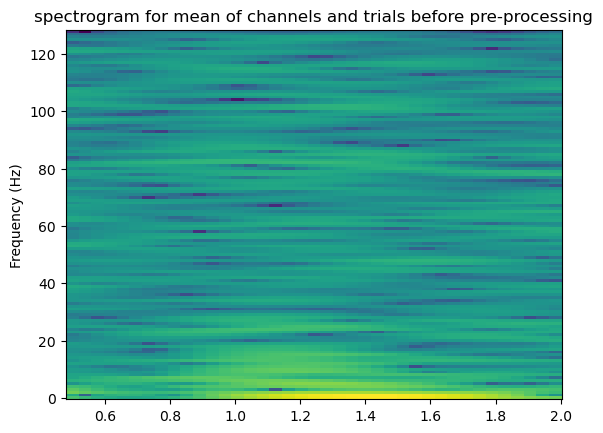

In [97]:
### before preprocessing spectogram
fs = 256
plt.title('spectrogram for mean of channels and trials before pre-processing')
Pxx, freqs, bins, im = plt.specgram(EEG_selected_elc.mean(axis= 2).mean(axis=0),NFFT=2**8,noverlap=2**8-10,Fs=fs)
plt.pcolormesh(bins, freqs, 10*np.log10(Pxx))
plt.ylabel('Frequency (Hz)')
plt.show()

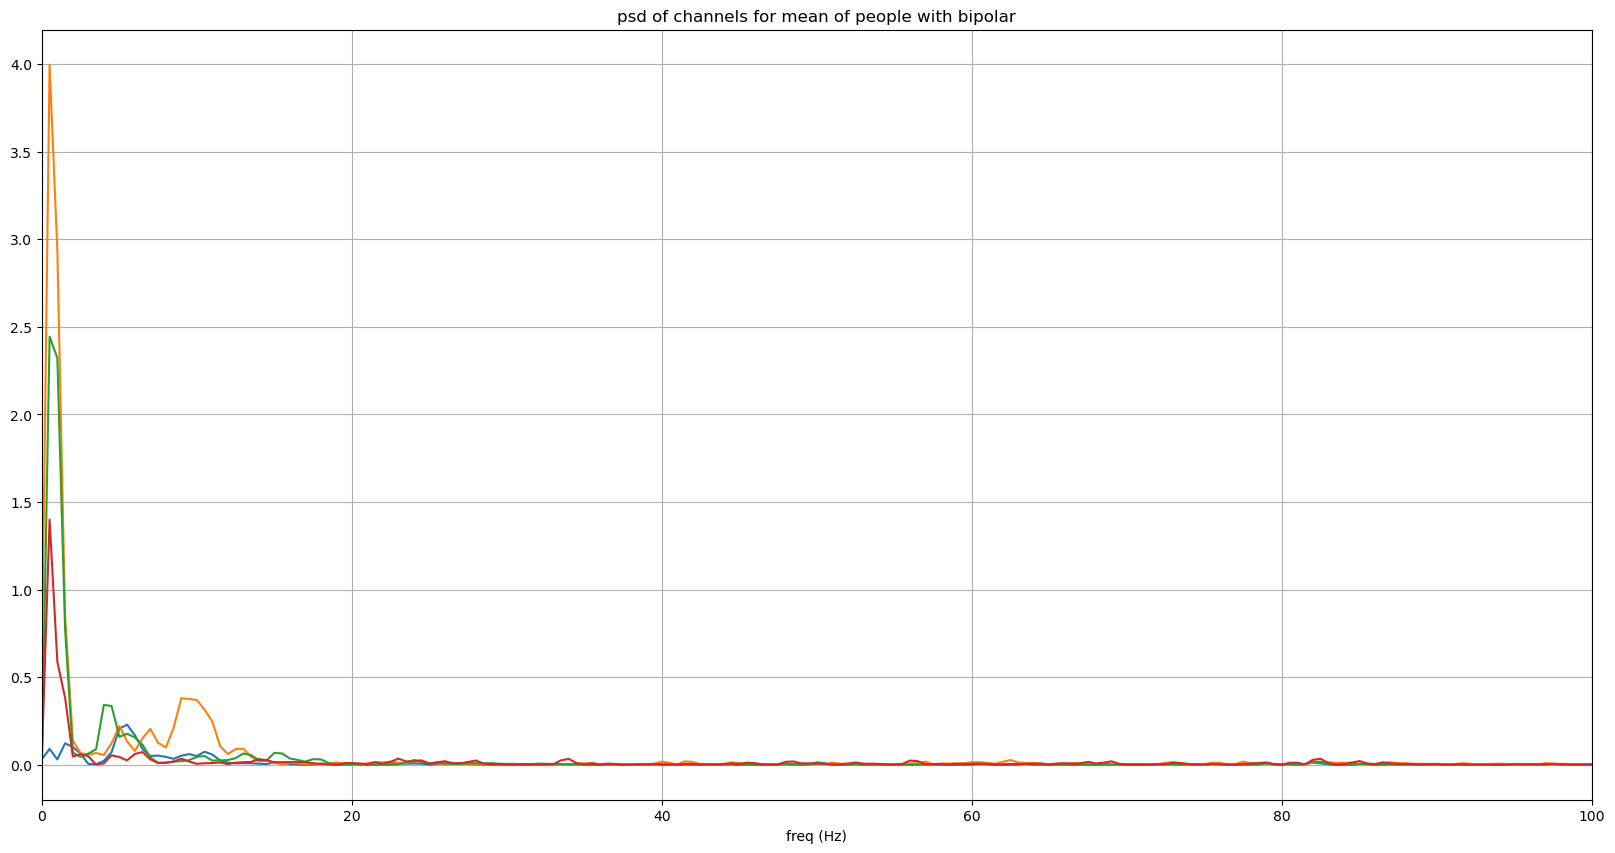

In [98]:
### before preprocessing PSD

from scipy import signal
plt.figure(figsize=(20, 10))
for j in range(4):
  #ax = plt.subplot(5, 4, j+1)
  #frs, power_spectrum = signal.welch((concatenated_df[j,:,0:2].mean(1)), fs, nperseg=fs)
  frs2, power_spectrum2 = signal.welch(EEG_selected_elc[j,:,:].mean(axis= 1), fs, nperseg=2*fs)
  #plt.plot(frs, 10*np.log10(power_spectrum))
  plt.plot(frs2, power_spectrum2)
  plt.title('psd of channels for mean of people with bipolar')
  plt.xlim([0,100])
  plt.grid(True)
  plt.xlabel('freq (Hz)')
  #plt.show()

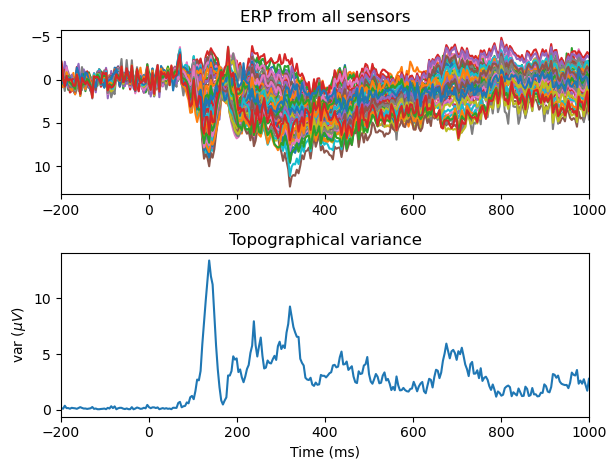

In [99]:
plt.figure()

plt.subplot(211)
plt.plot(EEGtimes,np.squeeze(EEGdata.mean(axis=2)).T)
plt.xlim([-200, 1000])
plt.gca().invert_yaxis() #flip for EEG conventions
plt.title("ERP from all sensors")

#topographical variance plot

plt.subplot(212)
plt.plot(EEGtimes,np.squeeze(EEGdata.mean(axis=2).var(axis=0)))
plt.xlim([-200,1000])
plt.xlabel("Time (ms)")
plt.ylabel("var "+r'$ (\mu V) $')
plt.title("Topographical variance")
plt.tight_layout()

## Preprocessing

In [100]:
### hann window
window = np.hanning(640)  # Create Hanning window

# Apply the window to each segment of your data
for i in range(4):  # For each channel
    for j in range(99):  # For each trial
        EEG_selected_elc[i, :, j] = EEG_selected_elc[i, :, j] * window
# plot (window)

In [101]:
### band-pass filter
dt = (EEGtimes[1] - EEGtimes[0])*0.001
fNQ = 1 / dt / 2         

filter_low = 5 #Hz
filter_high = 40 # Hz
b, a = sig.butter(5, np.array([filter_low/fNQ, filter_high/fNQ]),btype="bandpass")
EEG_selected_elc = sig.filtfilt(b, a, EEG_selected_elc)
# it seems there is no need to use a notch filter

## Plots after Preprocessing

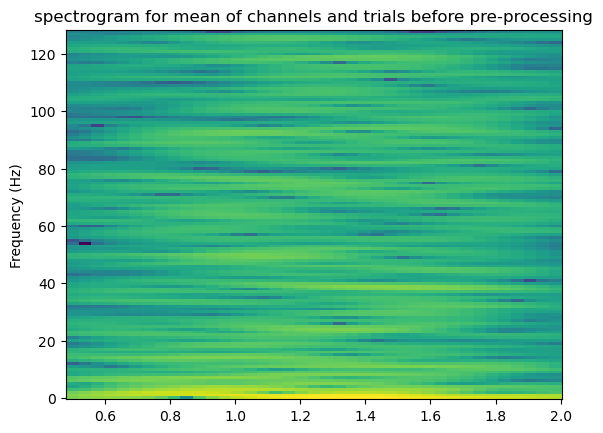

In [102]:
### before preprocessing spectogram
fs = 256
plt.title('spectrogram for mean of channels and trials before pre-processing')
Pxx, freqs, bins, im = plt.specgram(EEG_selected_elc.mean(axis= 2).mean(axis=0),NFFT=2**8,noverlap=2**8-10,Fs=fs)
plt.pcolormesh(bins, freqs, 10*np.log10(Pxx))
plt.ylabel('Frequency (Hz)')
plt.show()

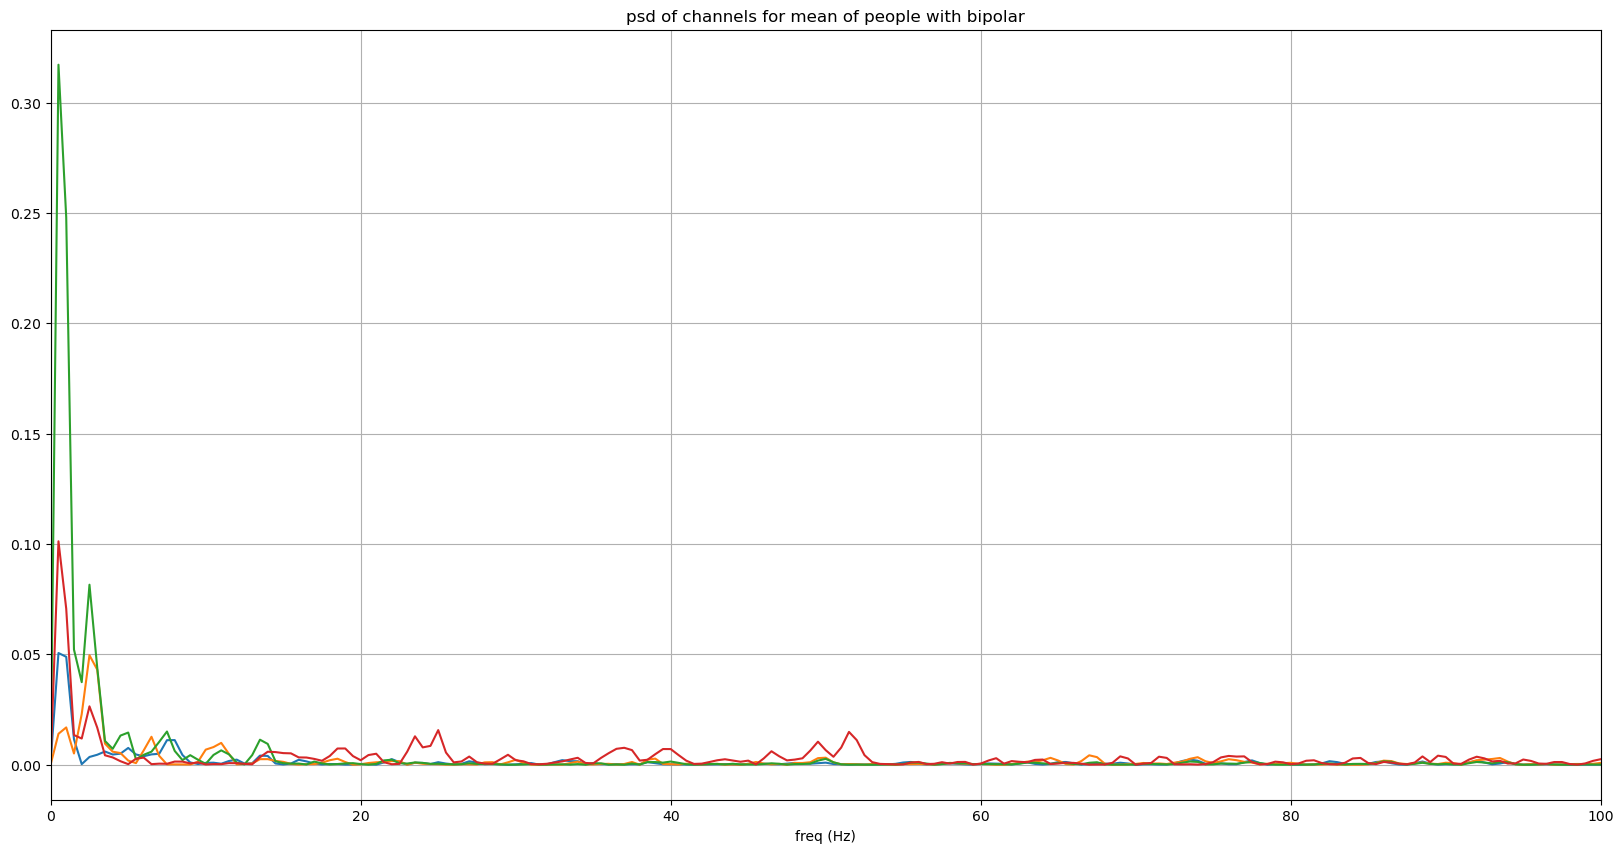

In [103]:
### before preprocessing PSD

from scipy import signal
plt.figure(figsize=(20, 10))
for j in range(4):
  #ax = plt.subplot(5, 4, j+1)
  #frs, power_spectrum = signal.welch((concatenated_df[j,:,0:2].mean(1)), fs, nperseg=fs)
  frs2, power_spectrum2 = signal.welch(EEG_selected_elc[j,:,:].mean(axis= 1), fs, nperseg=2*fs)
  #plt.plot(frs, 10*np.log10(power_spectrum))
  plt.plot(frs2, power_spectrum2)
  plt.title('psd of channels for mean of people with bipolar')
  plt.xlim([0,100])
  plt.grid(True)
  plt.xlabel('freq (Hz)')
  #plt.show()

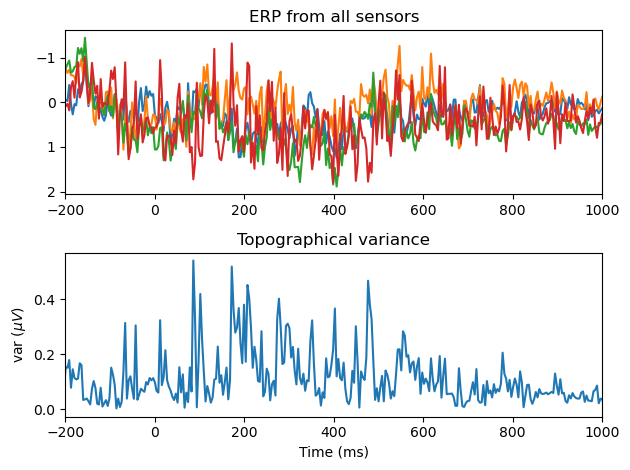

In [109]:
plt.figure()

plt.subplot(211)
plt.plot(EEGtimes,np.squeeze(EEG_selected_elc.mean(axis=2)).T)
plt.xlim([-200, 1000])
plt.gca().invert_yaxis() #flip for EEG conventions
plt.title("ERP from all sensors")

#topographical variance plot

plt.subplot(212)
plt.plot(EEGtimes,np.squeeze(EEG_selected_elc.mean(axis=2).var(axis=0)))
plt.xlim([-200,1000])
plt.xlabel("Time (ms)")
plt.ylabel("var "+r'$ (\mu V) $')
plt.title("Topographical variance")
plt.tight_layout()

## topoplot

In [105]:
# create mne Evoked object
import mne
import pymatreader
# load data using MNE
data_in = pymatreader.read_mat('sampleEEGdata.mat')
EEG = data_in['EEG']

# create channel montage
chan_labels = EEG['chanlocs']['labels']
coords = np.vstack([EEG['chanlocs']['Y'],EEG['chanlocs']['X'],EEG['chanlocs']['Z']]).T
montage = mne.channels.make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = mne.create_info(chan_labels, EEG['srate'] ,ch_types='eeg')
evoked = mne.EvokedArray(EEG['data'].mean(axis=2), info, tmin=EEG['xmin'])
evoked.set_montage(montage);

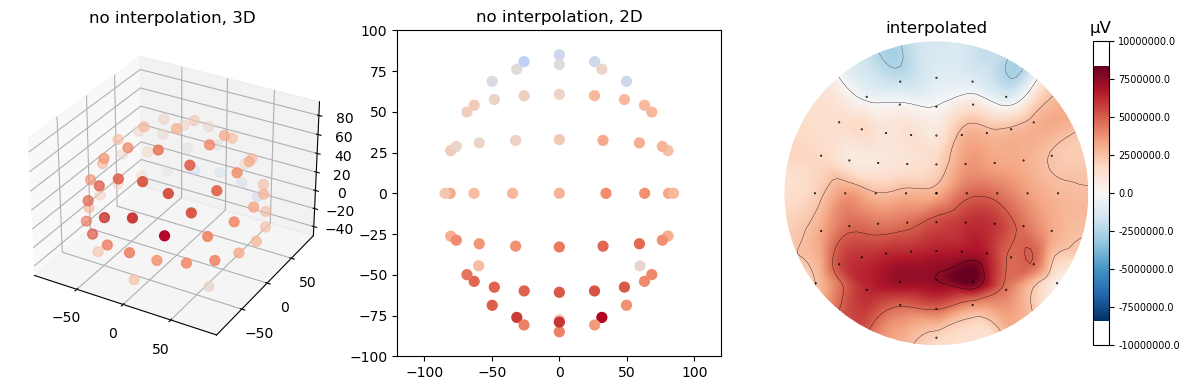

In [106]:
# topoplot with colored dots vs. interpolated surface
from mpl_toolkits.axes_grid1 import make_axes_locatable


# average voltage over trials for a given timepoint
TOI = 300 # ms
c = EEG['data'].mean(axis=2)[:, np.argmin(abs(EEG['times'] - TOI))]

# create figure
fig = plt.figure(figsize=(12,4), tight_layout=True)

# plot topomap without interpolation, 3D
clim = np.max(np.abs(c))
ax_1 = fig.add_subplot(131, projection='3d')
ax_1.scatter(EEG['chanlocs']['Y'], EEG['chanlocs']['X'],
             EEG['chanlocs']['Z'], s=50, c=c,
             cmap='coolwarm', vmin=-clim, vmax=clim)
ax_1.set(title='no interpolation, 3D')

# plot topomap without interpolation
ax_2 = fig.add_subplot(132)
ax_2.scatter(EEG['chanlocs']['Y'], EEG['chanlocs']['X'], s=50, c=c,
             cmap='coolwarm', vmin=-clim, vmax=clim)
ax_2.set(title='no interpolation, 2D')
ax_2.set_xlim([-120,120])
ax_2.set_ylim([-100,100])

# plot interpolated data
# make colorbar axis
ax_3 = fig.add_subplot(133)
divider = make_axes_locatable(ax_3)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax_3.set(title='interpolated')
evoked.plot_topomap(times=TOI/1000, axes=(ax_3, cax), time_format='');

## Reaction time calculation

In [107]:
rts = np.zeros(len(EEGepoch))

for ei in range(len(EEGepoch)):

    #first, find the index at which time = 0 event occurs
    time0event =  EEGepoch[ei]["eventlatency"][0]  == 0 #bool array of where time=0 occurs
    time0event = np.where(time0event == time0event.max())[0][0] # find the index of the True value in this array
    rts[ei] = EEGepoch[ei]["eventlatency"][0][time0event+1]


## Entropy of 30 first and last trials of each channel

In [113]:
import numpy as np
from scipy.stats import entropy


# Select the first and last 30 trials for each channel
selected_data_first= EEG_selected_elc[:, :30, :]
selected_data_last = EEG_selected_elc[:, -30:, :]

# Calculate entropy for each channel
entropy_values_first = np.zeros(selected_data_first.shape[0])  # Initialize an array to hold the entropy values
entropy_values_last = np.zeros(selected_data_last.shape[0])  # Initialize an array to hold the entropy values

for i in range(selected_data_first.shape[0]):
    # Flatten the trials and samples dimensions to create a 1D array for each channel
    flattened_data = selected_data_first[i, :, :].flatten()
    
    # Calculate histogram
    hist = np.histogram(flattened_data, bins='auto', density=True)[0]
    
    # Calculate and store entropy
    entropy_values_first[i] = entropy(hist)


for i in range(selected_data_last.shape[0]):
    # Flatten the trials and samples dimensions to create a 1D array for each channel
    flattened_data = selected_data_last[i, :, :].flatten()
    
    # Calculate histogram
    hist = np.histogram(flattened_data, bins='auto', density=True)[0]
    
    # Calculate and store entropy
    entropy_values_last[i] = entropy(hist)

print("Entropy values for the first 30 trials of each channel:", entropy_values_first)
print("Entropy values for the last 30 trials of each channel:", entropy_values_last)

Entropy values for the first 30 trials of each channel: [3.61461652 3.65278654 3.58478866 3.60521473]
Entropy values for the last 30 trials of each channel: [3.59327275 3.60471431 3.53142326 3.59447754]
